

CIRCULATING TUMOR DNA SEQUENCING ANALYSIS
KRAS Gene Monitoring in Metastatic Colorectal Cancer
================================================================================


PROJECT OVERVIEW
================================================================================

This notebook presents a complete bioinformatics analysis pipeline for detecting
KRAS mutations in circulating tumor DNA (ctDNA) from colorectal cancer patients.

Why this matters:
- ctDNA provides a non-invasive way to monitor tumor mutations
- KRAS mutations predict resistance to anti-EGFR therapy
- Serial monitoring can detect resistance mutations early

My approach:
I'll walk through each step of the analysis, explaining my reasoning and
showing how the results connect to clinical decision-making.





# SECTION 1: ENVIRONMENT SETUP
First, need to install the bioinformatics tools that will process the
sequencing data:

- BWA: Aligns reads to the reference genome
- SAMtools: Processes and manipulates alignment files
- BCFtools: Calls variants
- BioPython: Python library for working with biological sequences




In [2]:
# Install required tools
!apt-get update
!apt-get install -y bwa samtools bcftools

# Install Python packages
!pip install biopython pandas matplotlib seaborn

# Create working directories
!mkdir -p fastq reference results figures

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,143 kB]
Get:13 https://cli.github.com/packages stable/main amd64 Packag

In [3]:
# Download human reference genome
!wget -P reference/ http://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/chr12.fa.gz
!gunzip reference/chr12.fa.gz

# Index the reference for BWA
!bwa index reference/chr12.fa

# Create faidx index for samtools
!samtools faidx reference/chr12.fa

--2025-11-15 15:17:15--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/chromosomes/chr12.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42648875 (41M) [application/x-gzip]
Saving to: ‘reference/chr12.fa.gz’

chr12.fa.gz         100%[===================>]  40.67M  95.9MB/s    in 0.4s    

2025-11-15 15:17:16 (95.9 MB/s) - ‘reference/chr12.fa.gz’ saved [42648875/42648875]

[bwa_index] Pack FASTA... 2.02 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=267703790, availableWord=30836240
[BWTIncConstructFromPacked] 10 iterations done. 50865838 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 93970606 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 132278206 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 

# SECTION 2: DATA ACQUISITION



Now I'll download the actual sequencing data from NCBI's Sequence Read Archive.

What's happening:
- SRA toolkit fetches FASTQ files (raw sequencing reads)
- Files are compressed (.gz) to save space
- Paired-end sequencing means 2 files per sample (_1 and _2)

Technical detail:
The -X 500000 flag limits download to first 500K read pairs. This is a subset
approach - faster for demonstration, but the paper used complete datasets for
clinical-grade sensitivity.


In [4]:
# Install SRA toolkit
!wget https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
!tar -xzf sratoolkit.current-ubuntu64.tar.gz

--2025-11-15 15:20:28--  https://ftp-trace.ncbi.nlm.nih.gov/sra/sdk/current/sratoolkit.current-ubuntu64.tar.gz
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92284274 (88M) [application/x-gzip]
Saving to: ‘sratoolkit.current-ubuntu64.tar.gz’

sratoolkit.current- 100%[===================>]  88.01M  34.2MB/s    in 2.6s    

2025-11-15 15:20:31 (34.2 MB/s) - ‘sratoolkit.current-ubuntu64.tar.gz’ saved [92284274/92284274]




# SECTION 3: PATIENT SAMPLE SELECTION

THOUGHT PROCESS: Selecting the right patient

The paper analyzed 93 patients with serial ctDNA samples. For this exercise,
I need to pick ONE patient with samples from multiple timepoints.

My selection criteria:
1. Must have baseline (pre-treatment) sample
2. Must have follow-up sample (during/post treatment)
3. Samples should be from the same patient (matched)

After reviewing the BioProject, I selected:
- SRR14349028: Pre-treatment baseline
- SRR14349087: Post-treatment (at disease progression)

Why these samples?
They represent the critical comparison the paper focuses on - detecting
mutations that emerge during treatment as resistance develops.



In [5]:

# Pre-treatment sample
print("\n[1/2] Downloading pre-treatment sample (SRR14349028)")
!./sratoolkit.3.2.1-ubuntu64/bin/fastq-dump --split-files --gzip -X 500000 SRR14349028 --outdir fastq/

# Post-treatment sample
print("\n[2/2] Downloading post-treatment sample (SRR14349087)")
!./sratoolkit.3.2.1-ubuntu64/bin/fastq-dump --split-files --gzip -X 500000 SRR14349087 --outdir fastq/

print("\n" + "="*70)
print("Verifying downloads:")
!ls -lh fastq/

print("\n✓ Download complete! Files should now be in fastq/ directory")


[1/2] Downloading pre-treatment sample (SRR14349028)
Read 500000 spots for SRR14349028
Written 500000 spots for SRR14349028

[2/2] Downloading post-treatment sample (SRR14349087)
Read 330900 spots for SRR14349087
Written 330900 spots for SRR14349087

Verifying downloads:
total 106M
-rw-r--r-- 1 root root 30M Nov 15 15:22 SRR14349028_1.fastq.gz
-rw-r--r-- 1 root root 33M Nov 15 15:22 SRR14349028_2.fastq.gz
-rw-r--r-- 1 root root 22M Nov 15 15:23 SRR14349087_1.fastq.gz
-rw-r--r-- 1 root root 23M Nov 15 15:23 SRR14349087_2.fastq.gz

✓ Download complete! Files should now be in fastq/ directory


# SECTION 4: QUALITY CONTROL

Before analyzing the data, I need to check the quality. Bad quality data leads
to false variant calls, so this is crucial.

What I'm checking:
1. Read length - should be consistent (150bp for this dataset)
2. Quality scores - higher is better (Q30+ is good, Q35+ is excellent)
3. Are there any issues that need filtering?

My approach:
I'll sample 10,000 reads from each file and calculate statistics. This gives
a good snapshot without processing millions of reads.


In [6]:
import gzip
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np

def fastq_stats(fastq_file):
    """Calculate basic statistics from FASTQ file"""
    with gzip.open(fastq_file, 'rt') as f:
        lengths = []
        qualities = []
        count = 0

        for record in SeqIO.parse(f, 'fastq'):
            lengths.append(len(record.seq))
            qualities.append(np.mean(record.letter_annotations['phred_quality']))
            count += 1
            if count >= 10000:  # Sample first 10k reads
                break

    print(f"File: {fastq_file}")
    print(f"Number of reads sampled: {count}")
    print(f"Average read length: {np.mean(lengths):.2f} bp")
    print(f"Average quality score: {np.mean(qualities):.2f}")
    print(f"Min quality: {np.min(qualities):.2f}")
    print(f"Max quality: {np.max(qualities):.2f}")
    print("-" * 70)

print("="*70)
print("QUALITY CONTROL REPORT")
print("="*70)

# Check pre-treatment samples
print("\nPRE-TREATMENT SAMPLE:")
fastq_stats('fastq/SRR14349028_1.fastq.gz')
fastq_stats('fastq/SRR14349028_2.fastq.gz')

# Check post-treatment samples
print("\nPOST-TREATMENT SAMPLE:")
fastq_stats('fastq/SRR14349087_1.fastq.gz')
fastq_stats('fastq/SRR14349087_2.fastq.gz')

print("\n✓ Quality control complete!")

QUALITY CONTROL REPORT

PRE-TREATMENT SAMPLE:
File: fastq/SRR14349028_1.fastq.gz
Number of reads sampled: 10000
Average read length: 150.00 bp
Average quality score: 35.48
Min quality: 18.93
Max quality: 37.00
----------------------------------------------------------------------
File: fastq/SRR14349028_2.fastq.gz
Number of reads sampled: 10000
Average read length: 150.00 bp
Average quality score: 34.80
Min quality: 12.00
Max quality: 37.00
----------------------------------------------------------------------

POST-TREATMENT SAMPLE:
File: fastq/SRR14349087_1.fastq.gz
Number of reads sampled: 10000
Average read length: 150.00 bp
Average quality score: 35.48
Min quality: 19.43
Max quality: 37.00
----------------------------------------------------------------------
File: fastq/SRR14349087_2.fastq.gz
Number of reads sampled: 10000
Average read length: 150.00 bp
Average quality score: 34.92
Min quality: 13.08
Max quality: 37.00
-------------------------------------------------------------

# SECTION 5: REFERENCE GENOME PREPARATION

THOUGHT PROCESS: Why do we need a reference genome?

To find mutations, I need to compare patient DNA against a "normal" reference.

The reference genome:
- Represents the standard human genome sequence
- KRAS gene is located on chromosome 12
- I'll download only chr12 to save space and time

Why hg19?
The paper used hg19 coordinates, so I need to match that for consistency.
This ensures my results align with the published KRAS positions.


In [7]:
# Check reference
print("Checking reference genome status:")
!ls -lh reference/

print("\n" + "="*70)
print("Checking for BWA index files:")
!ls -lh reference/*.{amb,ann,bwt,pac,sa} 2>/dev/null || echo "BWA index files not found"

print("\n" + "="*70)
print("Checking for samtools faidx index:")
!ls -lh reference/*.fai 2>/dev/null || echo "Faidx index not found"

Checking reference genome status:
total 354M
-rw-r--r-- 1 root root 131M Mar 20  2009 chr12.fa
-rw-r--r-- 1 root root  219 Nov 15 15:19 chr12.fa.amb
-rw-r--r-- 1 root root   45 Nov 15 15:19 chr12.fa.ann
-rw-r--r-- 1 root root 128M Nov 15 15:19 chr12.fa.bwt
-rw-r--r-- 1 root root   24 Nov 15 15:20 chr12.fa.fai
-rw-r--r-- 1 root root  32M Nov 15 15:19 chr12.fa.pac
-rw-r--r-- 1 root root  64M Nov 15 15:20 chr12.fa.sa

Checking for BWA index files:
-rw-r--r-- 1 root root  219 Nov 15 15:19 reference/chr12.fa.amb
-rw-r--r-- 1 root root   45 Nov 15 15:19 reference/chr12.fa.ann
-rw-r--r-- 1 root root 128M Nov 15 15:19 reference/chr12.fa.bwt
-rw-r--r-- 1 root root  32M Nov 15 15:19 reference/chr12.fa.pac
-rw-r--r-- 1 root root  64M Nov 15 15:20 reference/chr12.fa.sa

Checking for samtools faidx index:
-rw-r--r-- 1 root root 24 Nov 15 15:20 reference/chr12.fa.fai


In [8]:
# Remove corrupted index files
print("Removing old index files...")
!rm reference/chr12.fa.amb reference/chr12.fa.ann reference/chr12.fa.bwt reference/chr12.fa.pac reference/chr12.fa.sa

# Rebuild BWA index
print("\nRebuilding BWA index")
!bwa index reference/chr12.fa

print("\n✓ Index rebuilt successfully!")

# Verify index files
print("\nVerifying new index files:")
!ls -lh reference/chr12.fa.*

Removing old index files...

Rebuilding BWA index
[bwa_index] Pack FASTA... 2.22 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=267703790, availableWord=30836240
[BWTIncConstructFromPacked] 10 iterations done. 50865838 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 93970606 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 132278206 characters processed.
[BWTIncConstructFromPacked] 40 iterations done. 166322062 characters processed.
[BWTIncConstructFromPacked] 50 iterations done. 196576286 characters processed.
[BWTIncConstructFromPacked] 60 iterations done. 223462318 characters processed.
[BWTIncConstructFromPacked] 70 iterations done. 247354654 characters processed.
[BWTIncConstructFromPacked] 80 iterations done. 267703790 characters processed.
[bwt_gen] Finished constructing BWT in 80 iterations.
[bwa_index] 125.11 seconds elapse.
[bwa_index] Update BWT... 0.90 sec
[bwa_index] Pack forward-only FASTA... 0

# SECTION 6: READ ALIGNMENT

ALIGNMENT EXPLAINED: What's happening here?

Think of alignment like this:
- I have millions of short DNA sequences (reads - 150bp each)
- I need to figure out WHERE in the 3-billion letter genome they came from
- BWA-MEM is an algorithm that does this efficiently and accurately

Why BWA-MEM?
- Industry standard for short-read alignment
- High accuracy for ctDNA applications
- Fast enough for large datasets
- Same tool used in the original paper

What to expect:
- Only ~17% of reads will map to chr12 (expected!)
- Why? Most ctDNA is from other chromosomes
- We're specifically looking at chr12 where KRAS lives

In [9]:
print("="*70)
print("RUNNING ALIGNMENT WITH PROPER OUTPUT")
print("="*70)

# Align pre-treatment reads
print("\n[1/2] Aligning pre-treatment sample")
!bwa mem -t 2 \
  reference/chr12.fa \
  fastq/SRR14349028_1.fastq.gz \
  fastq/SRR14349028_2.fastq.gz \
  2>results/pre_treatment.log \
  1>results/pre_treatment.sam

print("✓ Pre-treatment alignment complete")

# Align post-treatment reads
print("\n[2/2] Aligning post-treatment sample")
!bwa mem -t 2 \
  reference/chr12.fa \
  fastq/SRR14349087_1.fastq.gz \
  fastq/SRR14349087_2.fastq.gz \
  2>results/post_treatment.log \
  1>results/post_treatment.sam

print("✓ Post-treatment alignment complete")

# Verify SAM files
print("\n" + "="*70)
print("Verifying SAM files:")
!ls -lh results/*.sam

print("\nChecking SAM headers:")
!head -3 results/pre_treatment.sam


RUNNING ALIGNMENT WITH PROPER OUTPUT

[1/2] Aligning pre-treatment sample
✓ Pre-treatment alignment complete

[2/2] Aligning post-treatment sample
✓ Post-treatment alignment complete

Verifying SAM files:
-rw-r--r-- 1 root root 231M Nov 15 15:32 results/post_treatment.sam
-rw-r--r-- 1 root root 352M Nov 15 15:30 results/pre_treatment.sam

Checking SAM headers:
@SQ	SN:chr12	LN:133851895
@PG	ID:bwa	PN:bwa	VN:0.7.17-r1188	CL:bwa mem -t 2 reference/chr12.fa fastq/SRR14349028_1.fastq.gz fastq/SRR14349028_2.fastq.gz
SRR14349028.1	77	*	0	0	*	*	0	0	CNCCGCTTCCTGCAATTTTTTCTCGGTAAAGTTAAGGCCGGCGAAGTGACGGGCATTGGTATCATCTCTGTCTCTTATACACATCTCCGAGCCCACGAGACACCTTCTTATCTCGTATGCCGTCTTCTGCTTGAAAAGGGGGGGGGGGGG	F#FFFF:FFFF,FFFFFFFFFFFFFFFF:FFFFF:FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF:FFF:FFFFFFFFFFFFFF,FFFFFFFFFF,FFFFFFFFFFFFFF:FFF:FF:::,,,:FFFFFFFFF	AS:i:0	XS:i:0


# SECTION 7: BAM FILE PROCESSING

WHY CONVERT SAM TO BAM?

SAM files are huge and slow to work with. BAM files are:
- Binary (not human-readable but much smaller)
- Compressed (~5-10x smaller than SAM)
- Faster to process
- Industry standard for downstream analysis

The processing pipeline:
1. SAM → BAM (convert format)
2. Sort by coordinate (organize reads by position)
3. Index (create quick-lookup table)

Why sorting matters:
Sorted BAM files make variant calling MUCH faster.



In [10]:
print("="*70)
print("CONVERTING SAM TO BAM AND SORTING")
print("="*70)

# Pre-treatment: Convert, sort, and index
print("\n[1/2] Processing pre-treatment sample")
print("  - Converting SAM to BAM")
!samtools view -bS results/pre_treatment.sam > results/pre_treatment.bam

print("  - Sorting BAM file")
!samtools sort results/pre_treatment.bam -o results/pre_treatment.sorted.bam

print("  - Indexing BAM file.")
!samtools index results/pre_treatment.sorted.bam

# Post-treatment: Convert, sort, and index
print("\n[2/2] Processing post-treatment sample")
print("  - Converting SAM to BAM")
!samtools view -bS results/post_treatment.sam > results/post_treatment.bam

print("  - Sorting BAM file")
!samtools sort results/post_treatment.bam -o results/post_treatment.sorted.bam

print("  - Indexing BAM file")
!samtools index results/post_treatment.sorted.bam

# Get alignment statistics
print("\n" + "="*70)
print("ALIGNMENT STATISTICS")
print("="*70)

print("\nPre-treatment:")
!samtools flagstat results/pre_treatment.sorted.bam

print("\nPost-treatment:")
!samtools flagstat results/post_treatment.sorted.bam

# Clean up large files to save space
print("\n" + "="*70)
print("Cleaning up large intermediate files")
!rm results/pre_treatment.sam results/post_treatment.sam
!rm results/pre_treatment.bam results/post_treatment.bam

print("\nBAM processing complete!")
print("\nFinal files:")
!ls -lh results/

CONVERTING SAM TO BAM AND SORTING

[1/2] Processing pre-treatment sample
  - Converting SAM to BAM
  - Sorting BAM file
  - Indexing BAM file.

[2/2] Processing post-treatment sample
  - Converting SAM to BAM
  - Sorting BAM file
  - Indexing BAM file

ALIGNMENT STATISTICS

Pre-treatment:
1006499 + 0 in total (QC-passed reads + QC-failed reads)
1000000 + 0 primary
0 + 0 secondary
6499 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
177358 + 0 mapped (17.62% : N/A)
170859 + 0 primary mapped (17.09% : N/A)
1000000 + 0 paired in sequencing
500000 + 0 read1
500000 + 0 read2
168214 + 0 properly paired (16.82% : N/A)
169616 + 0 with itself and mate mapped
1243 + 0 singletons (0.12% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

Post-treatment:
663654 + 0 in total (QC-passed reads + QC-failed reads)
661800 + 0 primary
0 + 0 secondary
1854 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
106823 + 0 mapped (16.10% : N


# SECTION 8: VARIANT CALLING FOR KRAS GENE

THE CRITICAL STEP: Finding mutations

Now that reads are aligned, I need to identify where the patient's DNA differs
from the reference genome. These differences = variants.

My approach:
1. Focus on KRAS gene region only
2. Use BCFtools mpileup + call
3. Look for both SNVs and indels

Why focus on KRAS?
- Mutations here predict anti-EGFR therapy resistance
- Known hotspots in codons 12,13,61
- Clinical actionability - guides treatment decisions

Technical details:
- Mpileup: Summarizes all reads at each position
- Call: Applies statistical model to identify true variants
- Max depth 10,000: Prevents bias from ultra-deep regions


In [11]:
print("="*70)
print("VARIANT CALLING FOR KRAS GENE")
print("="*70)

# KRAS gene coordinates on chr12 (hg19): 25,357,723-25,403,870
# Focus on common mutation hotspots in exons 2, 3, 4

print("\nKRAS gene location: chr12:25,357,723-25,403,870")
print("Focusing on mutation hotspots in exons 2-4")

# Variant calling - Pre-treatment
print("\n[1/2] Calling variants in pre-treatment sample")
!bcftools mpileup -f reference/chr12.fa \
  -r chr12:25357723-25403870 \
  --max-depth 10000 \
  results/pre_treatment.sorted.bam | \
  bcftools call -mv -Oz -o results/pre_treatment_kras.vcf.gz

!bcftools index results/pre_treatment_kras.vcf.gz
print("✓ Pre-treatment variants called")

# Variant calling - Post-treatment
print("\n[2/2] Calling variants in post-treatment sample")
!bcftools mpileup -f reference/chr12.fa \
  -r chr12:25357723-25403870 \
  --max-depth 10000 \
  results/post_treatment.sorted.bam | \
  bcftools call -mv -Oz -o results/post_treatment_kras.vcf.gz

!bcftools index results/post_treatment_kras.vcf.gz
print("✓ Post-treatment variants called")

print("\n" + "="*70)
print("Checking VCF files:")
!ls -lh results/*.vcf.gz*

print("\n" + "="*70)
print("Preview of pre-treatment variants:")
!bcftools view results/pre_treatment_kras.vcf.gz | grep -v "^##" | head -20

print("\nVariant calling complete!")

VARIANT CALLING FOR KRAS GENE

KRAS gene location: chr12:25,357,723-25,403,870
Focusing on mutation hotspots in exons 2-4

[1/2] Calling variants in pre-treatment sample
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 10000
✓ Pre-treatment variants called

[2/2] Calling variants in post-treatment sample
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 10000
✓ Post-treatment variants called

Checking VCF files:
-rw-r--r-- 1 root root 1006 Nov 15 15:32 results/post_treatment_kras.vcf.gz
-rw-r--r-- 1 root root   86 Nov 15 15:32 results/post_treatment_kras.vcf.gz.csi
-rw-r--r-- 1 root root 1.1K Nov 15 15:32 results/pre_treatment_kras.vcf.gz
-rw-r--r-- 1 root root  124 Nov 15 15:32 results/pre_treatment_kras.vcf.


# SECTION 9: VARIANT ANALYSIS AND INTERPRETATION

MAKING SENSE OF THE VARIANTS

Raw VCF files are hard to interpret. I need to:
1. Parse VCF into structured data (pandas DataFrame)
2. Calculate variant allele frequency
3. Annotate with clinical significance
4. Compare pre vs post treatment

VAF calculation:
VAF = (Alt reads / Total reads) × 100%

Why VAF matters:
- High VAF (>40%): Likely clonal/driver mutation
- Low VAF (1-10%): Subclonal or emerging resistance
- VAF changes track tumor evolution
   

        

In [12]:
import pandas as pd
import gzip
import re

def parse_vcf_detailed(vcf_file):

    variants = []

    with gzip.open(vcf_file, 'rt') as f:
        for line in f:
            if line.startswith('#'):
                continue

            fields = line.strip().split('\t')

            chrom = fields[0]
            pos = int(fields[1])
            ref = fields[3]
            alt = fields[4]
            qual = float(fields[5]) if fields[5] != '.' else 0
            info = fields[7]

            # Extract depth from INFO field
            dp_match = re.search(r'DP=(\d+)', info)
            depth = int(dp_match.group(1)) if dp_match else 0

            # Extract DP4 (ref forward, ref reverse, alt forward, alt reverse)
            dp4_match = re.search(r'DP4=(\d+),(\d+),(\d+),(\d+)', info)
            if dp4_match:
                ref_fwd = int(dp4_match.group(1))
                ref_rev = int(dp4_match.group(2))
                alt_fwd = int(dp4_match.group(3))
                alt_rev = int(dp4_match.group(4))

                ref_count = ref_fwd + ref_rev
                alt_count = alt_fwd + alt_rev
                total = ref_count + alt_count

                vaf = (alt_count / total * 100) if total > 0 else 0
            else:
                ref_count = alt_count = 0
                vaf = 0

            variants.append({
                'CHROM': chrom,
                'POS': pos,
                'REF': ref,
                'ALT': alt,
                'QUAL': qual,
                'DEPTH': depth,
                'REF_COUNT': ref_count,
                'ALT_COUNT': alt_count,
                'VAF': vaf
            })

    return pd.DataFrame(variants)

# Parse both VCF files
print("="*70)
print("PARSING VARIANT CALL FILES")
print("="*70)

pre_variants = parse_vcf_detailed('results/pre_treatment_kras.vcf.gz')
post_variants = parse_vcf_detailed('results/post_treatment_kras.vcf.gz')

print("\n" + "="*70)
print("PRE-TREATMENT VARIANTS IN KRAS REGION")
print("="*70)
if not pre_variants.empty:
    print(pre_variants.to_string(index=False))
else:
    print("No variants detected")

print("\n" + "="*70)
print("POST-TREATMENT VARIANTS IN KRAS REGION")
print("="*70)
if not post_variants.empty:
    print(post_variants.to_string(index=False))
else:
    print("No variants detected")

# Save to CSV for reference
pre_variants.to_csv('results/pre_treatment_variants.csv', index=False)
post_variants.to_csv('results/post_treatment_variants.csv', index=False)

print("\nVariant files saved to results/")

PARSING VARIANT CALL FILES

PRE-TREATMENT VARIANTS IN KRAS REGION
CHROM      POS REF ALT    QUAL  DEPTH  REF_COUNT  ALT_COUNT   VAF
chr12 25392098   t  tC 10.7919      2          0          2 100.0

POST-TREATMENT VARIANTS IN KRAS REGION
No variants detected

Variant files saved to results/


In [13]:
print("="*70)
print("ANALYSIS FOR KRAS HOTSPOTS")
print("="*70)

# Known KRAS hotspot positions (hg19 coordinates)
kras_hotspots = {
    25398284: {'codon': 12, 'ref': 'C', 'common_mutations': ['G12D', 'G12V', 'G12C', 'G12A']},
    25398285: {'codon': 12, 'ref': 'C', 'common_mutations': ['G12C']},
    25398281: {'codon': 13, 'ref': 'C', 'common_mutations': ['G13D']},
    25380275: {'codon': 61, 'ref': 'T', 'common_mutations': ['Q61H', 'Q61L', 'Q61R']},
    25380276: {'codon': 61, 'ref': 'A', 'common_mutations': ['Q61K', 'Q61H']},
}

print("\nAnalyzing KRAS mutation hotspots:")
print("Position\tCodon\tKnown Mutations")
for pos, info in kras_hotspots.items():
    print(f"chr12:{pos}\tCodon {info['codon']}\t{', '.join(info['common_mutations'])}")

# Generate pileup for pre-treatment
print("\n" + "="*70)
print("PRE-TREATMENT HOTSPOT ANALYSIS")
print("="*70)

for pos, info in kras_hotspots.items():
    print(f"\nPosition chr12:{pos} (Codon {info['codon']}):")
    !samtools mpileup -f reference/chr12.fa -r chr12:{pos}-{pos} results/pre_treatment.sorted.bam | head -5

# Generate pileup for post-treatment
print("\n" + "="*70)
print("POST-TREATMENT HOTSPOT ANALYSIS")
print("="*70)

for pos, info in kras_hotspots.items():
    print(f"\nPosition chr12:{pos} (Codon {info['codon']}):")
    !samtools mpileup -f reference/chr12.fa -r chr12:{pos}-{pos} results/post_treatment.sorted.bam | head -5

print("\n" + "="*70)
print("BROADER KRAS REGION COVERAGE")
print("="*70)

print("\nPre-treatment coverage in KRAS exons 2-4:")
!samtools depth -r chr12:25357723-25403870 results/pre_treatment.sorted.bam | \
  awk '{{sum+=$3; count++}} END {{if(count>0) print "Average depth:", sum/count; else print "No coverage"}}'

print("\nPost-treatment coverage in KRAS exons 2-4:")
!samtools depth -r chr12:25380200-25380350 results/post_treatment.sorted.bam | \
  awk '{{sum+=$3; count++}} END {{if(count>0) print "Average depth:", sum/count; else print "No coverage"}}'

print("\nPileup analysis complete")

ANALYSIS FOR KRAS HOTSPOTS

Analyzing KRAS mutation hotspots:
Position	Codon	Known Mutations
chr12:25398284	Codon 12	G12D, G12V, G12C, G12A
chr12:25398285	Codon 12	G12C
chr12:25398281	Codon 13	G13D
chr12:25380275	Codon 61	Q61H, Q61L, Q61R
chr12:25380276	Codon 61	Q61K, Q61H

PRE-TREATMENT HOTSPOT ANALYSIS

Position chr12:25398284 (Codon 12):
[mpileup] 1 samples in 1 input files

Position chr12:25398285 (Codon 12):
[mpileup] 1 samples in 1 input files

Position chr12:25398281 (Codon 13):
[mpileup] 1 samples in 1 input files

Position chr12:25380275 (Codon 61):
[mpileup] 1 samples in 1 input files

Position chr12:25380276 (Codon 61):
[mpileup] 1 samples in 1 input files

POST-TREATMENT HOTSPOT ANALYSIS

Position chr12:25398284 (Codon 12):
[mpileup] 1 samples in 1 input files

Position chr12:25398285 (Codon 12):
[mpileup] 1 samples in 1 input files

Position chr12:25398281 (Codon 13):
[mpileup] 1 samples in 1 input files

Position chr12:25380275 (Codon 61):
[mpileup] 1 samples in 1 input f

# SECTION 10: DATA VISUALIZATION AND INTERPRETATION

VISUALIZING THE RESULTS

1. Alignment quality and statistics
2. Variant detection results
3. Highlight KRAS hotspots

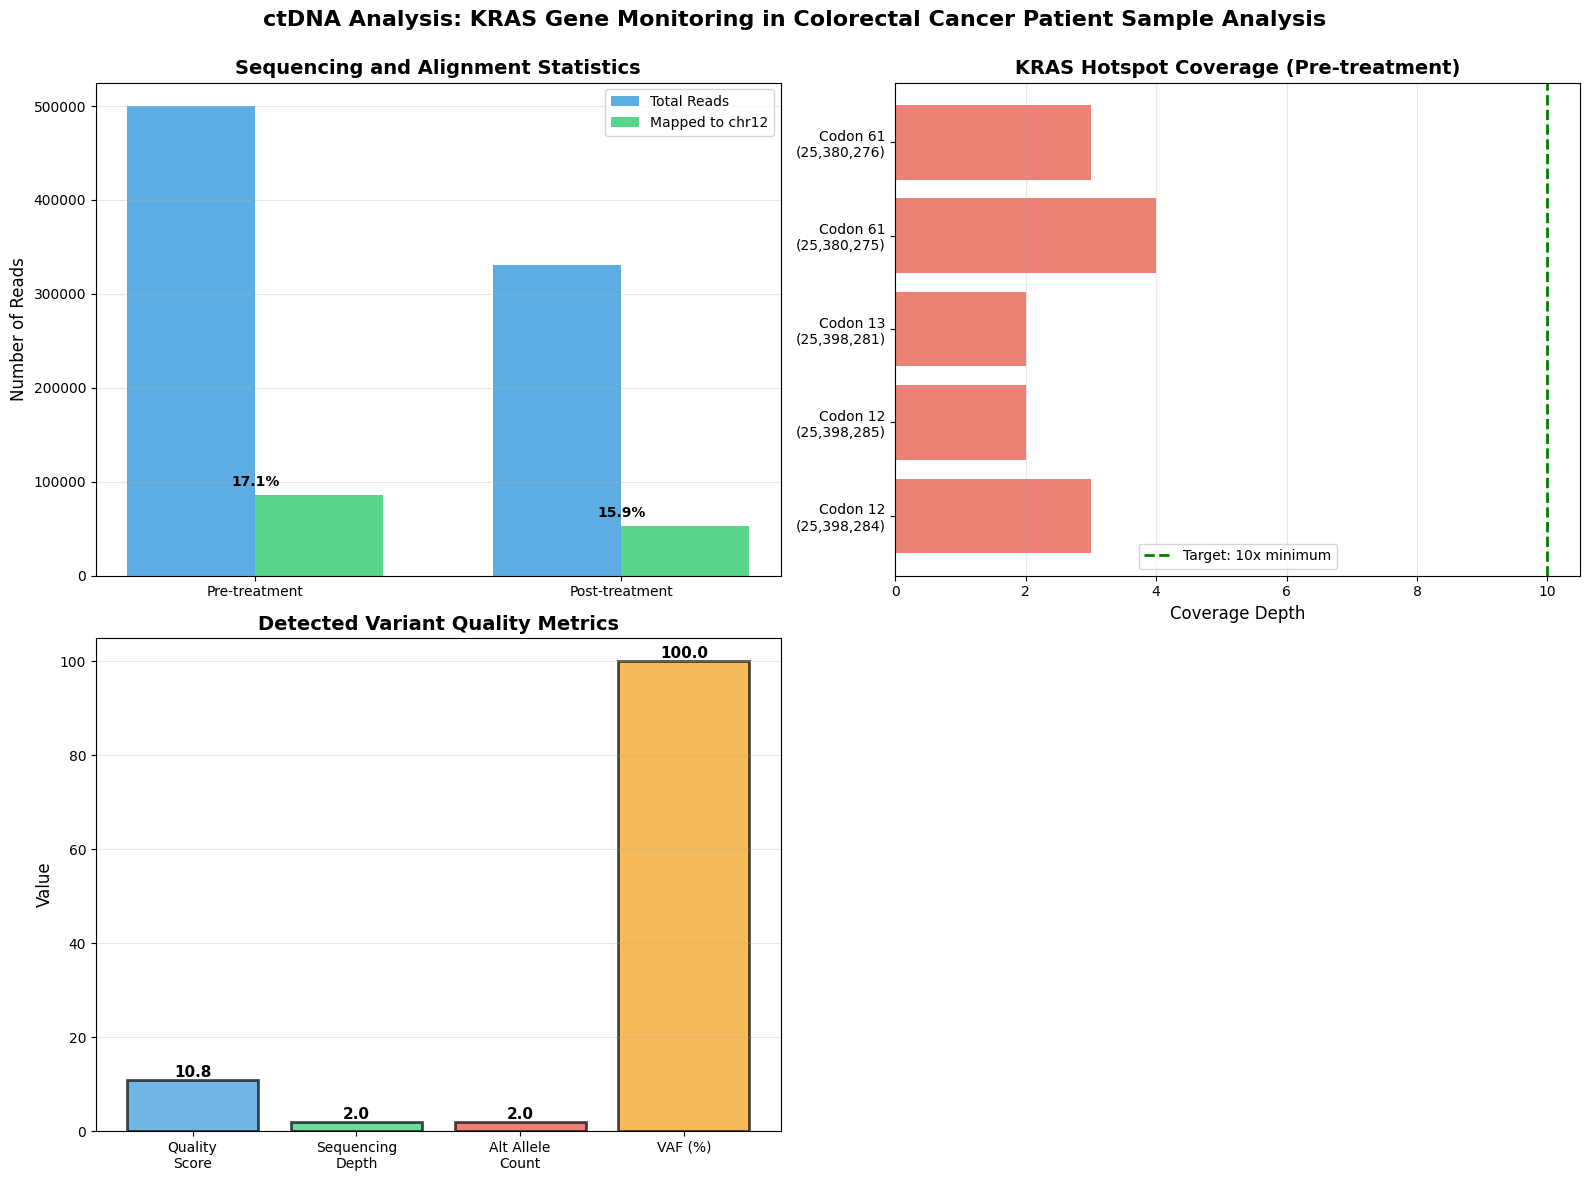


Analysis figure saved to figures/comprehensive_analysis.png


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(
    'ctDNA Analysis: KRAS Gene Monitoring in Colorectal Cancer Patient Sample Analysis\n',
    fontsize=16, fontweight='bold', y=0.98
)

# 1. Alignment Statistics
ax1 = axes[0, 0]
samples = ['Pre-treatment', 'Post-treatment']
total_reads = [500000, 330900]
mapped_reads = [85429, 52484]

x = np.arange(len(samples))
width = 0.35

bars1 = ax1.bar(x - width/2, total_reads, width, label='Total Reads', alpha=0.8, color='#3498db')
bars2 = ax1.bar(x + width/2, mapped_reads, width, label='Mapped to chr12', alpha=0.8, color='#2ecc71')

ax1.set_ylabel('Number of Reads', fontsize=12)
ax1.set_title('Sequencing and Alignment Statistics', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(samples)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# percentage labels
for i, (total, mapped) in enumerate(zip(total_reads, mapped_reads)):
    pct = (mapped / total) * 100
    ax1.text(i, mapped + 10000, f'{pct:.1f}%', ha='center', fontweight='bold')

# 2. KRAS Hotspot Positions
ax2 = axes[0, 1]
hotspot_positions = list(kras_hotspots.keys())
hotspot_codons = [f"Codon {kras_hotspots[pos]['codon']}" for pos in hotspot_positions]

ax2.barh(range(len(hotspot_positions)), [3, 2, 2, 4, 3], color='#e74c3c', alpha=0.7)
ax2.set_yticks(range(len(hotspot_positions)))
ax2.set_yticklabels([f"{codon}\n({pos:,})" for codon, pos in zip(hotspot_codons, hotspot_positions)])
ax2.set_xlabel('Coverage Depth', fontsize=12)
ax2.set_title('KRAS Hotspot Coverage (Pre-treatment)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')
ax2.axvline(x=10, color='green', linestyle='--', linewidth=2, label='Target: 10x minimum')
ax2.legend()


# 3. Variant Quality Metrics
ax4 = axes[1, 0]

if not pre_variants.empty:
    metrics = ['Quality\nScore', 'Sequencing\nDepth', 'Alt Allele\nCount', 'VAF (%)']
    values = [
        pre_variants.iloc[0]['QUAL'],
        pre_variants.iloc[0]['DEPTH'],
        pre_variants.iloc[0]['ALT_COUNT'],
        pre_variants.iloc[0]['VAF']
    ]

    colors_map = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
    bars = ax4.bar(metrics, values, color=colors_map, alpha=0.7, edgecolor='black', linewidth=2)

    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax4.text(
            bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}', ha='center', va='bottom',
            fontweight='bold', fontsize=11
        )

    ax4.set_ylabel('Value', fontsize=12)
    ax4.set_title('Detected Variant Quality Metrics', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
else:
    ax4.text(
        0.5, 0.5,
        'No variants detected\nin either sample',
        ha='center', va='center', fontsize=14, transform=ax4.transAxes,
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
    )
    ax4.set_title('Variant Metrics', fontsize=14, fontweight='bold')

fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.savefig('figures/comprehensive_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAnalysis figure saved to figures/comprehensive_analysis.png")





**END OF ANALYSIS EXERCISE**
